Filtered real data:
    learning_rate  batch_size  hidden_dim  num_layers  contrastive_dim   k  \
0         0.0005          64         128           3               16  64   
1         0.0005          64         128           3               16  32   
2         0.0005          64         128           3               64  64   
3         0.0005          64         128           3              512  32   
4         0.0005          64         128           5               64  64   

   best_val_loss  
0       0.002188  
1       0.003507  
2       0.002210  
3       0.003524  
4       0.002468  


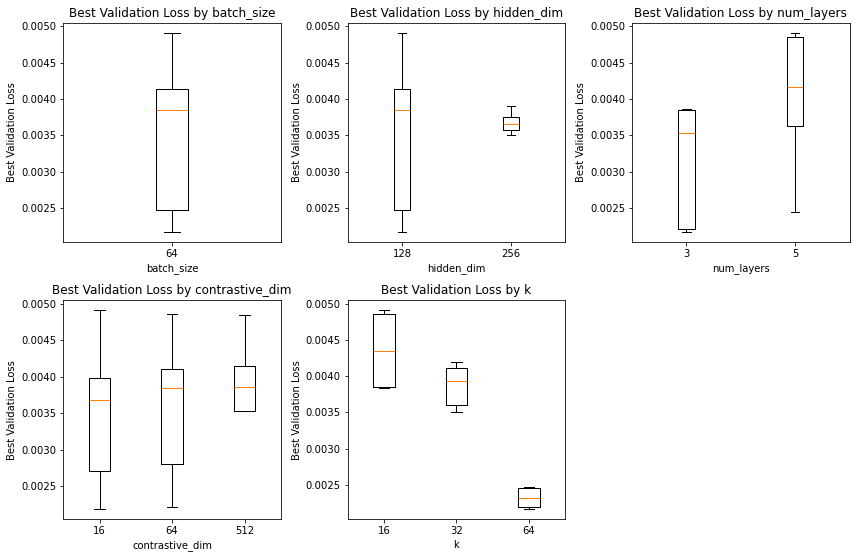

In [53]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def collect_results(root_dir):
    """
    Walk through 'root_dir', parse each folder named like:
      results_lr(.+)_bs(.+)_hd(.+)_nl(.+)_cd(.+)_k(.+)
    Extract the best val_loss from the corresponding CSV:
      results_lr{lr}_bs{bs}_hd{hd}_nl{nl}_cd{cd}_k{k}.csv
    Return a DataFrame containing the hyperparameters + best_val_loss.
    """
    all_results = []
    
    for folder in os.listdir(root_dir):
        if folder.startswith("results_"):
            folder_path = os.path.join(root_dir, folder)
            if not os.path.isdir(folder_path):
                continue

            csv_file = os.path.join(folder_path, folder + ".csv")
            if not os.path.exists(csv_file):
                continue

            # Read CSV and obtain the best validation loss
            df = pd.read_csv(csv_file)
            best_val_loss = df["val_loss"].min()

            # Adjust regex: DEC folders don't include heads now.
            match = re.match(
                r"results_lr(.+)_bs(.+)_hd(.+)_nl(.+)_cd(.+)_k(.+)",
                folder
            )
            if match:
                lr_str, bs_str, hd_str, nl_str, cd_str, k_str = match.groups()
                all_results.append({
                    "learning_rate": float(lr_str),
                    "batch_size": int(bs_str),
                    "hidden_dim": int(hd_str),
                    "num_layers": int(nl_str),
                    "contrastive_dim": int(cd_str),
                    "k": int(k_str),
                    "best_val_loss": best_val_loss
                })

    return pd.DataFrame(all_results)

def main():
    # 1) Collect real data from your DEC results folders
    root_dir = "/vols/cms/er421/hgcal/code/code/Mixed/LC/HyperDEC/results"
    df = collect_results(root_dir)

    # 2) Filter out invalid or large loss values
    df = df[df["best_val_loss"].notna()]   # remove NaNs
    df = df[df["best_val_loss"] <= 0.006]    # remove runs with loss > 0.006
    df = df.reset_index(drop=True)

    print("Filtered real data:\n", df.head())

    # 4) List of hyperparameters to visualize
    hyperparams = ["batch_size", "hidden_dim", "num_layers", "contrastive_dim", "k"]

    # 5) Create subplots for the five box plots (e.g., a 2x3 grid, one subplot will be unused)
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
    axes = axes.flatten()

    ##########################################################################
    # 6) For each parameter, build the distribution for each group and add custom data.
    ##########################################################################
    for idx, param in enumerate(hyperparams):
        ax = axes[idx]

        # Group real data by parameter: obtain a dict mapping each param value to its list of best_val_loss values.
        grouped = df.groupby(param)["best_val_loss"].apply(list).to_dict()

        # Merge in any custom points if provided for this parameter.
        if param in custom_points:
            for param_value, extra_vals in custom_points[param].items():
                if param_value not in grouped:
                    grouped[param_value] = []
                grouped[param_value].extend(extra_vals)

        # Sort parameter values to have a consistent order on the x-axis.
        sorted_param_values = sorted(grouped.keys())
        data_for_boxplot = [grouped[val] for val in sorted_param_values]

        # If there's no data for this parameter, label it and continue.
        if len(data_for_boxplot) == 0:
            ax.set_title(f"No data for {param}")
            ax.set_visible(True)
            continue

        # Create the box plot for this parameter while hiding outlier markers.
        ax.boxplot(data_for_boxplot, labels=sorted_param_values, showfliers=False)
        ax.set_title(f"Best Validation Loss by {param}")
        ax.set_xlabel(param)
        ax.set_ylabel("Best Validation Loss")

    # Hide any leftover subplots if there are more axes than parameters.
    for j in range(len(hyperparams), len(axes)):
        axes[j].set_visible(False)

    # Remove the default suptitle (if any) and tidy up the layout.
    fig.suptitle("")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Collected data:
   learning_rate  best_val_loss
0        0.00500       0.010226
1        0.01000       0.010851
2        0.00100       0.010881
3        0.00050       0.004284
4        0.00001       0.008976
5        0.00005       0.008133
6        0.00010       0.005606


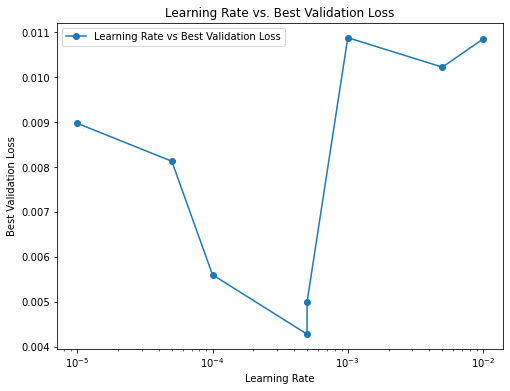

In [67]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def collect_lr_results(root_dir):
    """
    Walk through root_dir and parse folder names matching:
      results_lr{lr}_bs{bs}_hd{hd}_nl{nl}_temp{temp}_cd{cd}_k{k}
    
    For each folder, read the corresponding CSV file (assumed to have a 'val_loss' column)
    and extract the lowest (best) validation loss.
    
    Returns a DataFrame with columns:
       - learning_rate
       - best_val_loss
    """
    all_results = []
    for folder in os.listdir(root_dir):
        if folder.startswith("results_"):
            folder_path = os.path.join(root_dir, folder)
            if not os.path.isdir(folder_path):
                continue

            # Expect a CSV file with the same base name as the folder.
            csv_file = os.path.join(folder_path, folder + ".csv")
            if not os.path.exists(csv_file):
                continue

            df = pd.read_csv(csv_file)
            best_val_loss = df["val_loss"].min()

            # Extract parameters using regex. Adjust pattern if needed.
            match = re.match(
                r"results_lr(.+)_bs(.+)_hd(.+)_nl(.+)_temp(.+)_cd(.+)_k(.+)",
                folder
            )
            if match:
                lr_str, bs_str, hd_str, nl_str, temp_str, cd_str, k_str = match.groups()
                try:
                    lr = float(lr_str)
                except ValueError:
                    continue
                all_results.append({
                    "learning_rate": lr,
                    "best_val_loss": best_val_loss
                })
    return pd.DataFrame(all_results)

def main():
    # Set the directory containing your learning-rate experiment folders.
    root_dir = "/vols/cms/mm1221/hgcal/elec5New/LC/misc/results/lr/"
    
    # 1. Collect the data.
    df = collect_lr_results(root_dir)
    
    # 2. Filter out runs with missing best_val_loss or with loss > 0.011.
    df = df[df["best_val_loss"].notna()]
    df = df[df["best_val_loss"] <= 0.011]
    df = df.reset_index(drop=True)
    
    print("Collected data:")
    print(df)
    
    # 3. Sort the data by learning rate.
    df = df.sort_values(by="learning_rate")
    x = df["learning_rate"].values
    y = df["best_val_loss"].values
    
    # 4. OPTIONAL: Add your custom points.
    # You can specify extra points (for example, to highlight certain values)
    # by appending them to the arrays.
    # For instance, to add a point at learning_rate 0.0005 with best_val_loss 0.005:
    custom_x = np.array([0.0005])  # add as many values as desired
    custom_y = np.array([0.005])
    # Append custom points to the collected data.
    if custom_x.size and custom_y.size:
        x = np.concatenate((x, custom_x))
        y = np.concatenate((y, custom_y))
    
    # 5. Sort the arrays again after adding custom points.
    sort_idx = np.argsort(x)
    x = x[sort_idx]
    y = y[sort_idx]
    
    # 6. Plot the scatter plot with lines connecting the points.
    plt.figure(figsize=(8, 6))
    # 'o-' draws both the points and lines connecting them.
    plt.plot(x, y, 'o-', label="Learning Rate vs Best Validation Loss")
    plt.xlabel("Learning Rate")
    plt.ylabel("Best Validation Loss")
    plt.title("Learning Rate vs. Best Validation Loss")
    plt.xscale("log")  # Use a log scale on the x-axis.
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()


In [ ]:
Can you 